In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Example: The Duffing Oscillator

We are going to apply what we learned to the Duffing oscillator. The Duffing oscillator is a simple model for a forced oscillator with a nonlinear term. It is described by the following equation:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. We can rewrite this as a system of first order equations by introducing $v = \dot{x}$:

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{align}$$

The initial conditions are $x(0) = x_0$ and $v(0) = v_0$.
Denote by $\theta$ the vector of all parameters, i.e. $\theta = (\alpha, \beta, \gamma, \delta, \omega, x_0, v_0)$.
The vector field $f(x,v,t;\theta)$ is then given by:

$$f(x,v,t;\theta) = \begin{pmatrix}
v \\
\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{pmatrix}.$$

Let us start by writing some code that solves the problem for a given $\theta$, but purely in `Jax`.
We will use the [diffrax package](https://docs.kidger.site/diffrax/) written by Patrick Kidger.

In [61]:
import numpy as np
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt

def vector_field(t, y, theta):
    alpha, beta, gamma, delta, omega = theta[:5]
    x = y[0]
    v = y[1]
    return jnp.array(
        [
            v,
            - alpha * x - beta * x ** 3 - delta * v + gamma * jnp.cos(omega * t)
        ]
    )


theta = jnp.array([
    1.0,  # alpha
    5.0,  # beta
    0.37, # gamma
    0.1,  # delta
    1.0,  # omega
])

# The numerical solver to use.
solver = Tsit5()
# At which timesteps to store the solution.
saveat = SaveAt(ts=jnp.linspace(0, 50, 2000))
# The differential equation term.
term = ODETerm(vector_field)
# The Solution for one theta.
sol = diffeqsolve(
    term,
    solver,
    t0=0,                       # Initial time
    t1=50,                      # Terminal time
    dt0=0.1,                    # Initial timestep - it will be adjusted
    y0=jnp.array([0.0, 0.0]),   # Initial value
    args=theta,
    saveat=saveat
)

And here is how you can extract the solution:

In [62]:
print(sol.ys.shape)

(2000, 2)


Let's plot it:

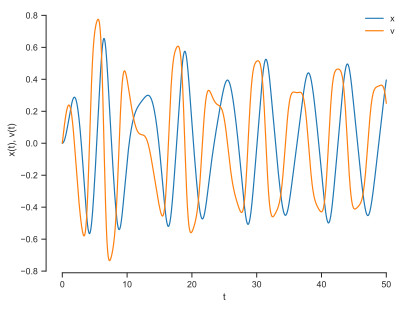

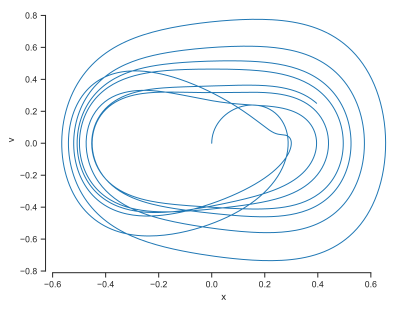

In [65]:
fig, ax = plt.subplots()
ax.plot(sol.ts, sol.ys[:, 0], label="x")
ax.plot(sol.ts, sol.ys[:, 1], label="v")
ax.set(xlabel="t", ylabel="x(t), v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(sol.ys[:, 0], sol.ys[:, 1], lw=1)
ax.set(xlabel="x", ylabel="v")
sns.despine(trim=True);

We see that the solution converges to a stable limit cycle for this particular value of the parameters.

Let's now add a bit of uncertainty in the parameters.
Say we about 5% uncertainty in the parameters $\alpha$, $\beta$, $\gamma$, $\delta$, and $\omega$.
We can do this by sampling from a normal distribution with mean $\theta$ and standard deviation 5% of $\theta$:

$$
\theta \sim \mathcal{N}\left(
\begin{pmatrix}
1 \\
5 \\
0.37 \\
0.1 \\
1
\end{pmatrix},
\begin{pmatrix}
0.05^2 & 0 & 0 & 0 & 0 \\
0 & 0.25^2 & 0 & 0 & 0 \\
0 & 0 & 0.0185^2 & 0 & 0 \\
0 & 0 & 0 & 0.005^2 & 0 \\
0 & 0 & 0 & 0 & 0.05^2
\end{pmatrix}
\right)
$$

To proceed, let's make a function that takes a parameter vector $\theta$ and returns the solution of the Duffing oscillator for that parameter vector:

In [66]:
def solve_duffing(theta):
    # The numerical solver to use.
    solver = Tsit5()
    # At which timesteps to store the solution.
    saveat = SaveAt(ts=jnp.linspace(0, 50, 2000))
    # The differential equation term.
    term = ODETerm(vector_field)
    # The Solution for one theta.
    sol = diffeqsolve(
        term,
        solver,
        t0=0,                       # Initial time
        t1=50,                      # Terminal time
        dt0=0.1,                    # Initial timestep - it will be adjusted
        y0=jnp.array([0.0, 0.0]),   # Initial value
        args=theta,
        saveat=saveat
    )
    return sol.ys

Okay, all we now how to do is differentiate and jit this function:

In [89]:
from jax import jacobian, jit

jit_solve_duffing = jit(solve_duffing)
jit_jac_solve_duffing = jit(jacobian(solve_duffing))

# Evaluate everything at the mean theta.
sol_mu = jit_solve_duffing(theta)
jac_sol_mu = jit_jac_solve_duffing(theta)

This is it, now we can do all sorts of things with this information.
Recall that the solution $Y=y(t;\theta)=(x(t;\theta), v(t;\theta))$ is a Gaussian process:

$$
Y \sim \text{GP}(y(t;\mu),\nabla_{\theta}y(t;\mu)\Sigma\nabla_{\theta}y(t';\mu)^T).
$$

Again, pay attention to the fact that this is a vector-valued Gaussian process - not a scalar-valued one.
So the covariance function is a matrix-valued function.
Here it is 2x2.

The quantity `sol_mu` is its mean function evaluated at 2,000 points in time between 0 and 50.
Similarly, `jac_sol_mu` is the Jacobian of the mean function evaluated at the same points in time.
The second can be used to evaluate the covariance function of the Gaussian process at the same points.

Let's get the covariance.
We can easily find it in one line using the function `einsum` from `Jax` or `Numpy`.
We use `NumPy` here because we have no plans of differentiating it.
If you don't know what `einsum` does, you can read about it [here](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).
It is immensely useful.
If you don't believe me watch.

We want to evaluate the covariance function of the vector-valued Gaussian process at all time steps.
Consider times $t_k$ and $t_r$ and dimensions $i$ and $j$.
Time steps go from $0$ to $2000$ and dimensions go from $0$ to $1$ (the dimension of the vector-valued Gaussian process, i.e., of the underlying ODE).
We need to evaluate:

$$
\begin{align*}
c_{krij} = c_{ij}(t_k,t_r) &= \nabla_{\theta}y_i(t;\mu)\Sigma\nabla_{\theta}y_j(t';\mu)^T\\
&= \sum_{l=0}^4 \sum_{m=0}^4 \nabla_{\theta_l}y_i(t_k;\mu)\Sigma_{lm}\nabla_{\theta_m}y_j(t_r;\mu)^T\\
&= \nabla_{\theta_l}y_i(t_k;\mu)\Sigma_{lm}\nabla_{\theta_m}y_j(t_r;\mu)^T\;\text{(Einstein summation)}
\end{align*}
$$

And here is the `einsum` call:

In [100]:
sol_cov = np.einsum("kil,lm,rjm->rkij", jac_sol_mu, Sigma, jac_sol_mu)
print(sol_cov.shape)

(2000, 2000, 2, 2)


I hope you appreciate the beauty of this.

Okay, now let's extract the diagonal of the covariance matrix so that we can make some nice predictive intervals.
We will use `einsum` again to extract the diagonal of the covariance matrix at all time steps:

In [105]:
tmp = np.einsum("kkii->ki", sol_cov)
x_std = np.sqrt(tmp[:, 0])
v_std = np.sqrt(tmp[:, 1])

Now we can plot the solution and the predictive intervals:

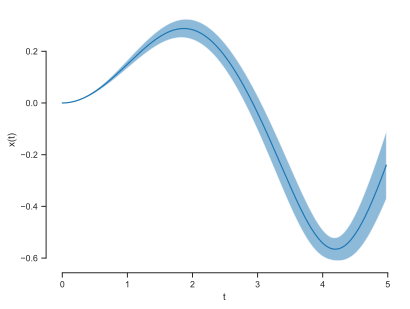

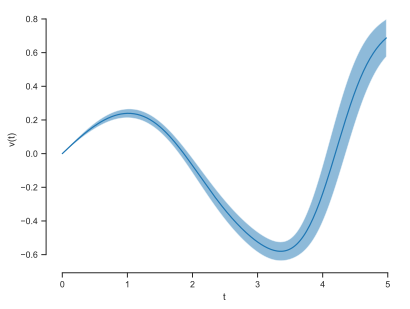

In [112]:
ts = np.linspace(0, 50, 2000)
steps_to_plot = 200
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 0], label="x")
ax.fill_between(
    ts[:steps_to_plot],
    sol_mu[:steps_to_plot, 0] - 2 * x_std[:steps_to_plot],
    sol_mu[:steps_to_plot, 0] + 2 * x_std[:steps_to_plot],
    alpha=0.5,
    label="2 std",
)
ax.set(xlabel="t", ylabel="x(t)")
sns.despine(trim=True)

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 1], label="v")
ax.fill_between(
    ts[:steps_to_plot],
    sol_mu[:steps_to_plot, 1] - 2 * v_std[:steps_to_plot],
    sol_mu[:steps_to_plot, 1] + 2 * v_std[:steps_to_plot],
    alpha=0.5,
    label="2 std",
)
ax.set(xlabel="t", ylabel="v(t)")
sns.despine(trim=True)


You may have noticed that, I din't plot the solution at all time steps.
This is because it is wrong after a certain point.
I will demonstrate this below.

But how good is our result? Let's do Monte Carlo sampling of the parameters so that we establish a ground truth for the solution.
We will use `vmap` to vectorize the function `solve_duffing` over the first axis of the parameter array `theta` and then use `jit` to compile the function:

In [68]:
from jax import jit, vmap

many_solve_duffing = jit(vmap(solve_duffing, in_axes=(0,)))

Let's do Monte Carlo:

In [76]:
num_thetas = 1_000_000
mu = np.array([1.0, 5.0, 0.37, 0.1, 1.0])
Sigma = np.diag((0.05 * mu) ** 2)
L = np.linalg.cholesky(Sigma)
thetas = np.random.randn(num_thetas, 5) @ L + mu
sols = many_solve_duffing(thetas)

Let's extract some statistics to compare:

In [80]:
mean_sol = np.mean(sols, axis=0)
std_sol = np.std(sols, axis=0)

Let's plot predictive intervals for 'x' and 'v' for the same time steps as before:

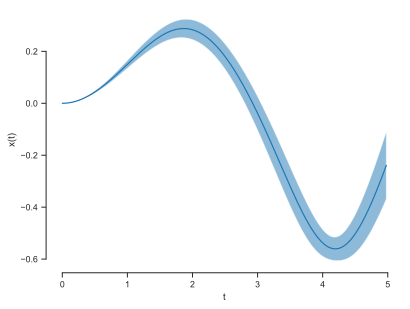

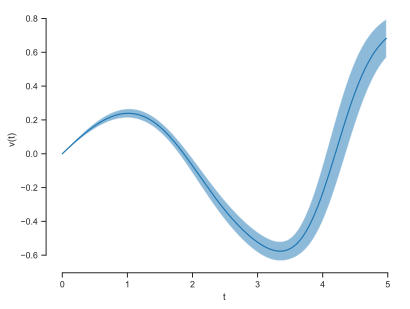

In [113]:
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 0], label="x")
ax.fill_between(
    ts[:steps_to_plot],
    mean_sol[:steps_to_plot, 0] - 2 * std_sol[:steps_to_plot, 0],
    mean_sol[:steps_to_plot, 0] + 2 * std_sol[:steps_to_plot, 0],
    alpha=0.5,
    label="2 std",
)
ax.set(xlabel="t", ylabel="x(t)")
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 1], label="v")
ax.fill_between(
    ts[:steps_to_plot],
    mean_sol[:steps_to_plot, 1] - 2 * std_sol[:steps_to_plot, 1],
    mean_sol[:steps_to_plot, 1] + 2 * std_sol[:steps_to_plot, 1],
    alpha=0.5,
    label="2 std",
)
ax.set(xlabel="t", ylabel="v(t)")
sns.despine(trim=True);

These look identical to the ones we got before.
Let's take a closer look.
First, let's compare the mean functions:

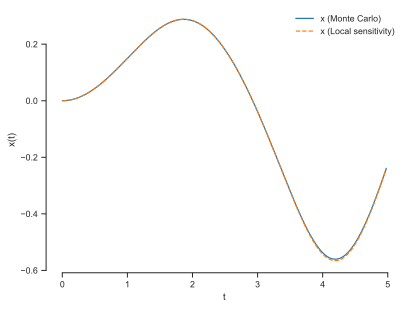

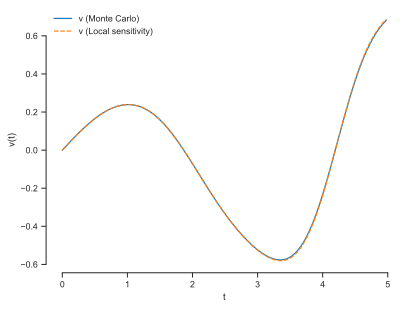

In [115]:
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 0], label="x (Monte Carlo)")
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 0], '--', label="x (Local sensitivity)")
ax.set(xlabel="t", ylabel="x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 1], label="v (Monte Carlo)")
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 1], '--', label="v (Local sensitivity)")
ax.set(xlabel="t", ylabel="v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

Pretty good. Now the standard deviations:

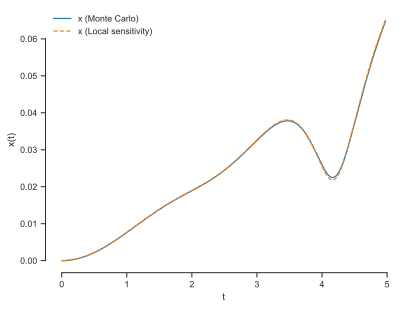

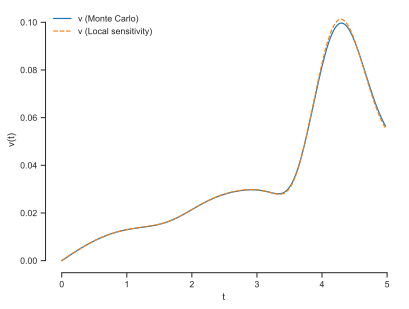

In [117]:
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], std_sol[:steps_to_plot, 0], label="x (Monte Carlo)")
ax.plot(ts[:steps_to_plot], x_std[:steps_to_plot], '--', label="x (Local sensitivity)")
ax.set(xlabel="t", ylabel="x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], std_sol[:steps_to_plot, 1], label="v (Monte Carlo)")
ax.plot(ts[:steps_to_plot], v_std[:steps_to_plot], '--', label="v (Local sensitivity)")
ax.set(xlabel="t", ylabel="v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

Also, pretty good - especially when we consider that it was very cheap to compute the local sensitivity results.

Okay, now let's see what happens if we try to predict the solution for a longer time.
We have already calculated everything, so all we need to do is open up the predictive intervals.

Here are the means:

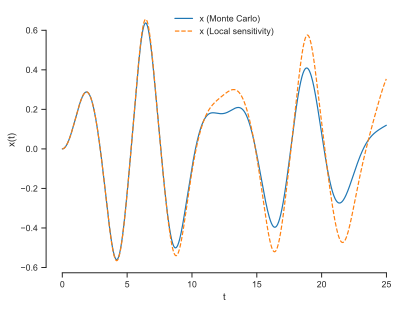

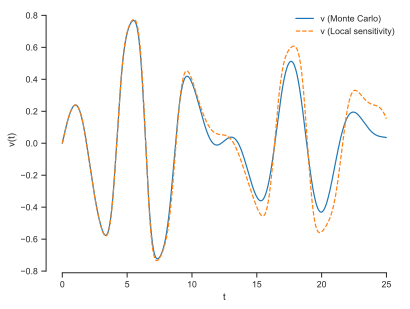

In [120]:
steps_to_plot = 1_000

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 0], label="x (Monte Carlo)")
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 0], '--', label="x (Local sensitivity)")
ax.set(xlabel="t", ylabel="x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mean_sol[:steps_to_plot, 1], label="v (Monte Carlo)")
ax.plot(ts[:steps_to_plot], sol_mu[:steps_to_plot, 1], '--', label="v (Local sensitivity)")
ax.set(xlabel="t", ylabel="v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

And here are the standard deviations:

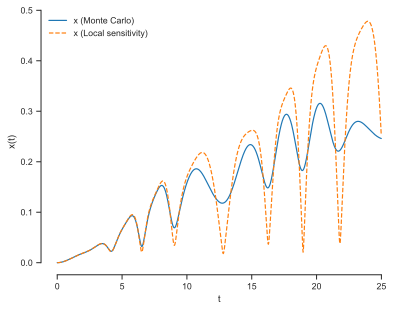

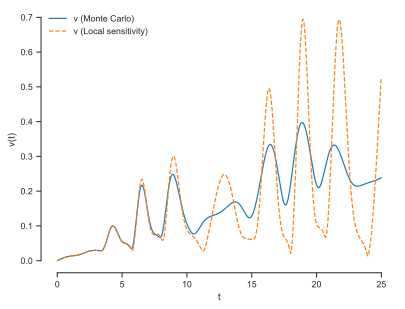

In [121]:
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], std_sol[:steps_to_plot, 0], label="x (Monte Carlo)")
ax.plot(ts[:steps_to_plot], x_std[:steps_to_plot], '--', label="x (Local sensitivity)")
ax.set(xlabel="t", ylabel="x(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], std_sol[:steps_to_plot, 1], label="v (Monte Carlo)")
ax.plot(ts[:steps_to_plot], v_std[:steps_to_plot], '--', label="v (Local sensitivity)")
ax.set(xlabel="t", ylabel="v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

We observe that the method does well at first, but then it progressively yields the wrong statistics.
This is expected with local sensitivity analysis whenever the solution is not a linear function of the parameters.